In [1]:
import torch
import numpy as np
import pandas as pd
import time
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from dataset import *
from spdnet.spd import SPDTransform, SPDTangentSpace, SPDRectified
from spdnet.optimizer import StiefelMetaOptimizer

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from utils import *

In [2]:
%cd ..

/Users/JJ/Desktop/fMRISPDCluster


In [6]:
MODEL='spd'
ID='1619422664'

path = f'./checkpoint/{MODEL}/{ID}/' 

args = load_args(path)
if args.model == 'spd':
    model = SPDNet(args.hs)
    train_data = SPDataset(scan_id=1, ws=args.ws)
    test_data = SPDataset(scan_id=2, ws=args.ws)
elif args.model == 'rspd':
    model = RSPDNet(args.hs, args.use_cuda)
    train_data = SPDRNNDataset(scan_id=1, ws=args.ws)
    test_data = SPDRNNDataset(scan_id=2, ws=args.ws)
if args.use_cuda:
    model = model.cuda()
    
model.load_state_dict(torch.load(os.path.join(path, 'ckpt.pth')))

train_data_loader = DataLoader(train_data, batch_size=args.bs, 
            shuffle=False, num_workers=4)
test_data_loader = DataLoader(test_data, batch_size=args.bs, 
            shuffle=False, num_workers=4)

10890
10890


In [10]:
activation = {}
z=[]
o=[]
c=[]

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

if args.model == 'spd':
    model.tangent.register_forward_hook(get_activation('o'))
    model.rect3.register_forward_hook(get_activation('z'))
elif args.model == 'rspd':
    model.output_layer.tangent.register_forward_hook(get_activation('o'))
    model.recurrent_layer.rect1.register_forward_hook(get_activation('z'))
    
for batch_idx, sample_batched in enumerate(test_data_loader):
    inputs = sample_batched['data']
    targets = sample_batched['label'].squeeze()

    if args.use_cuda:
        inputs = inputs.cuda()
        targets = targets.cuda()

    outputs = model(inputs)
    o += [activation['o']]
    z += [activation['z']]
    c += [targets]

In [11]:
o = torch.cat(o)
z = torch.cat(z)
c = torch.cat(c)

In [12]:
zx = []
for A in z:
    indices = np.triu_indices_from(A)
    A = np.asarray(A[indices])
    zx.append(A)
z = np.stack(zx)

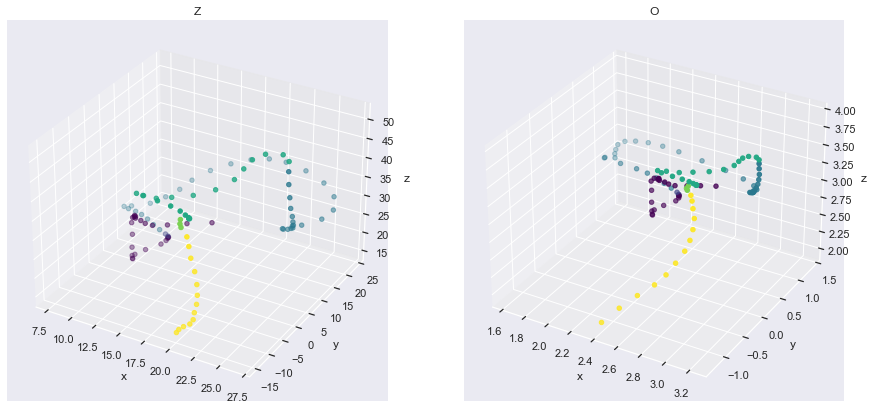

In [13]:

sns.set(style = "darkgrid")

fig = plt.figure(figsize=(15,10))

def embedding_viz(xyz, c, idx, tittle='z', N=100, perm=True):
    ax = fig.add_subplot(1, 2, idx, projection='3d')
    ax.title.set_text(tittle)
    idx = np.arange(len(c))
    if perm:
        idx = np.sort(np.random.permutation(idx))
    p = idx[:N]
    
    xs = xyz[p, 0]
    ys = xyz[p, 1]
    zs = xyz[p, 2]
    color = c[p]

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.scatter(xs, ys, zs, c=color, cmap='viridis')

    #for i, p in enumerate(zip(xs, ys, zs)):
    #    ax.text(p[0], p[1], p[2], str(int(c[i])), color="red", fontsize=7)

embedding_viz(z, c, 1, 'Z')
embedding_viz(o, c, 2, 'O')
plt.show()